# Anime Recommendations

<div>
<img src="images/Anime.jpeg" width="700"/>
</div>

<a href="https://www.fortressofsolitude.co.za/wp-content/uploads/2022/11/Top-10-Best-Anime-Series-Of-All-Time-Ranked-2048x1024.jpeg">Image Source</a></center>

In this project, our objective is to develop a robust anime recommendation system leveraging user ratings. The primary goal is to create a personalized anime recommendation engine that suggests anime titles to users based on their preferences and historical rating patterns. By employing advanced machine learning algorithms and data analysis techniques, we aim to enhance user engagement and satisfaction with anime content on our platform.

<a href="https://www.kaggle.com/datasets/CooperInion/anime-recommendations-database" target="_blank">Data Source</a>

The dataset comprises user preference data from 7813736 users spanning 12,294 anime titles. Each user has the option to include anime in their completed list and assign a rating. This dataset consolidates all the collected ratings from users' completed lists.

Data Dictionary

## Import Libraries

In [34]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',100)

import missingno as msno
## Setting the max_columns to 50
pd.set_option('display.max_columns',50)

## Load the dataset

In [35]:
# Load anime dataset

anime = pd.read_csv('Data/anime.csv')
anime.info()
anime.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [36]:
# Load ratings dataset

rating = pd.read_csv('Data/rating.csv')
rating.info()
rating.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## Checking for duplicate rows

In [37]:
# Check duplicates in anime 

animedup = anime.duplicated().sum()

print(f'There are {animedup} duplicate rows in the dataset.')

There are 0 duplicate rows in the dataset.


In [38]:
# Dropping duplicates

anime.drop_duplicates(inplace=True)

anime.duplicated().sum()

0

In [39]:
# Check duplicates in rating

ratingdup = rating.duplicated().sum()

print(f'There are {ratingdup} duplicate rows in the dataset.')

There are 1 duplicate rows in the dataset.


In [40]:
# Dropping duplicates

rating.drop_duplicates(inplace=True)

rating.duplicated().sum()

0

## Checking column's datatype 

In [41]:
# Preview all object columns from anime
anime.select_dtypes("object").head()

,name,genre,type,episodes
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51
3,Steins;Gate,"Sci-Fi, Thriller",TV,24
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51


- Object columns should be converted to numeric 
    - episodes

### Converting Object column to Numeric

In [42]:
try:
  anime["episodes"] = anime['episodes'].astype(float)
except Exception as e:
  display(e)

ValueError("could not convert string to float: 'Unknown'")

In [43]:
anime["episodes"].isna().sum()

0

In [76]:
# Checking all the rows with 'Unknown' in episodes column

unknown = anime[anime['episodes'] == 'Unknown']
unknown

,anime_id,name,genre,type,episodes,rating,members


#### Handling 'Unknown' in episodes
Many animes have unknown number of episodes even if they have similar rating. On top of that many super popular animes such as Naruto Shippuden, Attack on Titan Season 2 were ongoing when the data was collected, thus their number of episodes was considered as "Unknown". For some of my favorite animes I've filled in the episode numbers manually. For the other anime's, I had to make some educated guesses. Changes I've made are :

Animes that are grouped under Hentai Categories generally have 1 episode in my experience. So I've filled the unknown values with 1.

Animes that are grouped are "OVA" stands for "Original Video Animation". These are generally one/two episode long animes(often the popular ones have 2/3 episodes though), but I've decided to fill the unknown numbers of episodes with 1 again.

Animes that are grouped under "Movies" are considered as '1' episode as per the dataset overview goes.

For all the other animes with unknown number of episodes, I've filled the na values with the median which is 2.

In [75]:
anime.loc[(anime["genre"]=="Hentai") & (anime["episodes"]=="Unknown"),"episodes"] = "1"
anime.loc[(anime["type"]=="OVA") & (anime["episodes"]=="Unknown"),"episodes"] = "1"

anime.loc[(anime["type"] == "Movie") & (anime["episodes"] == "Unknown")] = "1"

In [70]:
known_animes = {"Naruto Shippuuden":500, "One Piece":784,"Detective Conan":854, "Dragon Ball Super":86,
                "Crayon Shin chan":942, "Yu Gi Oh Arc V":148,"Shingeki no Kyojin Season 2":25,
                "Boku no Hero Academia 2nd Season":25,"Little Witch Academia TV":25}

In [71]:

for k,v in known_animes.items():    
    anime.loc[anime["name"]==k,"episodes"] = v

In [73]:
anime["episodes"] = anime["episodes"].map(lambda x:np.nan if x=="Unknown" else x)


In [74]:
anime["episodes"].fillna(anime["episodes"].median(),inplace = True)

In [77]:
# Verify Unknown in anime

unknown

,anime_id,name,genre,type,episodes,rating,members


In [78]:
# Now convert episodes to anime
try:
  anime["episodes"] = anime['episodes'].astype(float)
except Exception as e:
  display(e)

In [79]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  object 
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  float64
 5   rating    12067 non-null  object 
 6   members   12294 non-null  object 
dtypes: float64(1), object(6)
memory usage: 768.4+ KB


## Checking for null values 

In [80]:
# Displaying null values for each feature in anime

anime.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      227
members       0
dtype: int64

In [81]:
# Displaying null values for each feature rating

rating.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

I will handle null values in the preprocessing step

## Combine Anime and rating dataframes

In [84]:
# merge 2 dataset
combinedata = pd.merge(anime,rating,on=['anime_id','anime_id'])
combinedata= combinedata[combinedata.user_id <= 20000]
combinedata.head(10)

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,278,-1
5,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,322,10
6,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,398,10
7,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,462,8
8,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,490,10
9,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,548,10


In [85]:
combinedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065588 entries, 0 to 7813678
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   anime_id  object 
 1   name      object 
 2   genre     object 
 3   type      object 
 4   episodes  float64
 5   rating_x  object 
 6   members   object 
 7   user_id   int64  
 8   rating_y  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 157.6+ MB


## Explanatory Data Analysis 

### Helper Functions

In [98]:
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
 
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing 
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot 
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")
  
  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()
      
  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax



In [99]:
# Final version of function
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna 
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x]) 
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  
    # Barplot 
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)
  
  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, 
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax



In [89]:
# Add **kwargs as keyword when defining function 
# Include **kwargs in the sns.regplot() within the function

def plot_numeric_vs_target(df, x, y='SalePrice', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax



In [90]:
combinedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2065588 entries, 0 to 7813678
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   anime_id  object 
 1   name      object 
 2   genre     object 
 3   type      object 
 4   episodes  float64
 5   rating_x  object 
 6   members   object 
 7   user_id   int64  
 8   rating_y  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 157.6+ MB


### Explore categorical columns

#### Inspect anime_id


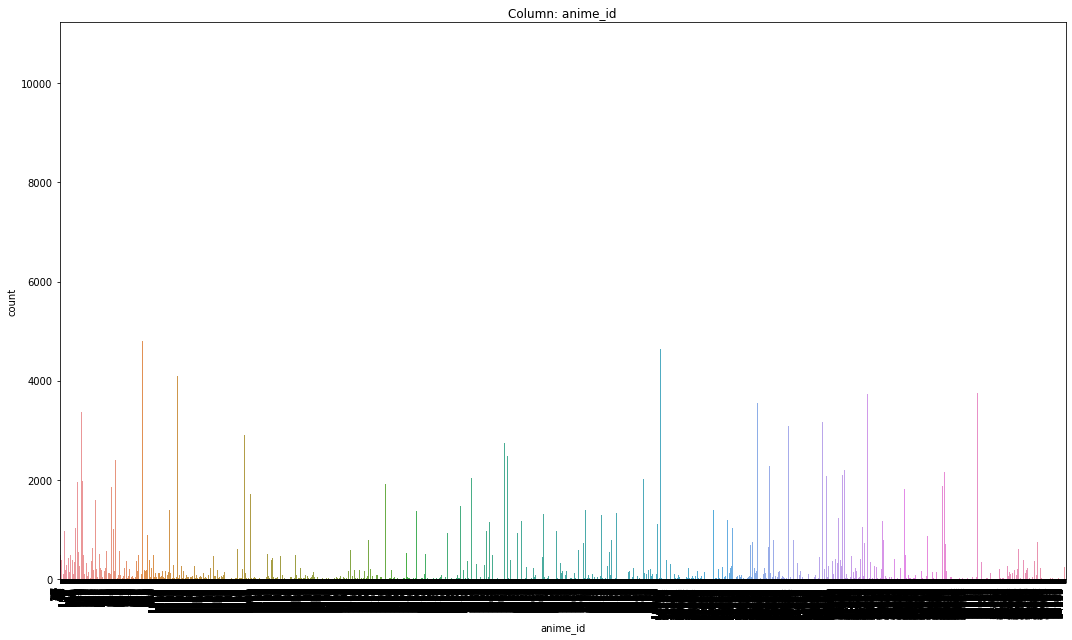

- NaN's Found: 0 (0.0%)
- Unique Values: 9277
- Most common value: '1535' occurs 10691 times (0.52%)
- Not constant or quasi-constant.


(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':'Column: anime_id'}, xlabel='anime_id', ylabel='count'>)

In [100]:
explore_categorical(combinedata, x = 'anime_id', fillna = True, placeholder = 'MISSING',
                        figsize = (15,9), order = None)

#### Inspect name


#### Inspect genre


In [96]:
combinedata['genre'].value_counts()

Comedy, School, Slice of Life                     15551
Hentai                                            15109
Action, Adventure, Fantasy, Game, Romance         14975
Comedy                                            14156
Comedy, Slice of Life                             13837
                                                  ...  
Drama, Mystery, Romance, Shoujo, Slice of Life        1
Drama, Horror, Romance                                1
Martial Arts, Seinen, Sports                          1
Adventure, Kids, Music                                1
Action, Historical, Military                          1
Name: genre, Length: 2962, dtype: int64

/var/folders/td/cybzgn316hq8r5cn05lb0y2m0000gn/T/ipykernel_74848/1906319003.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


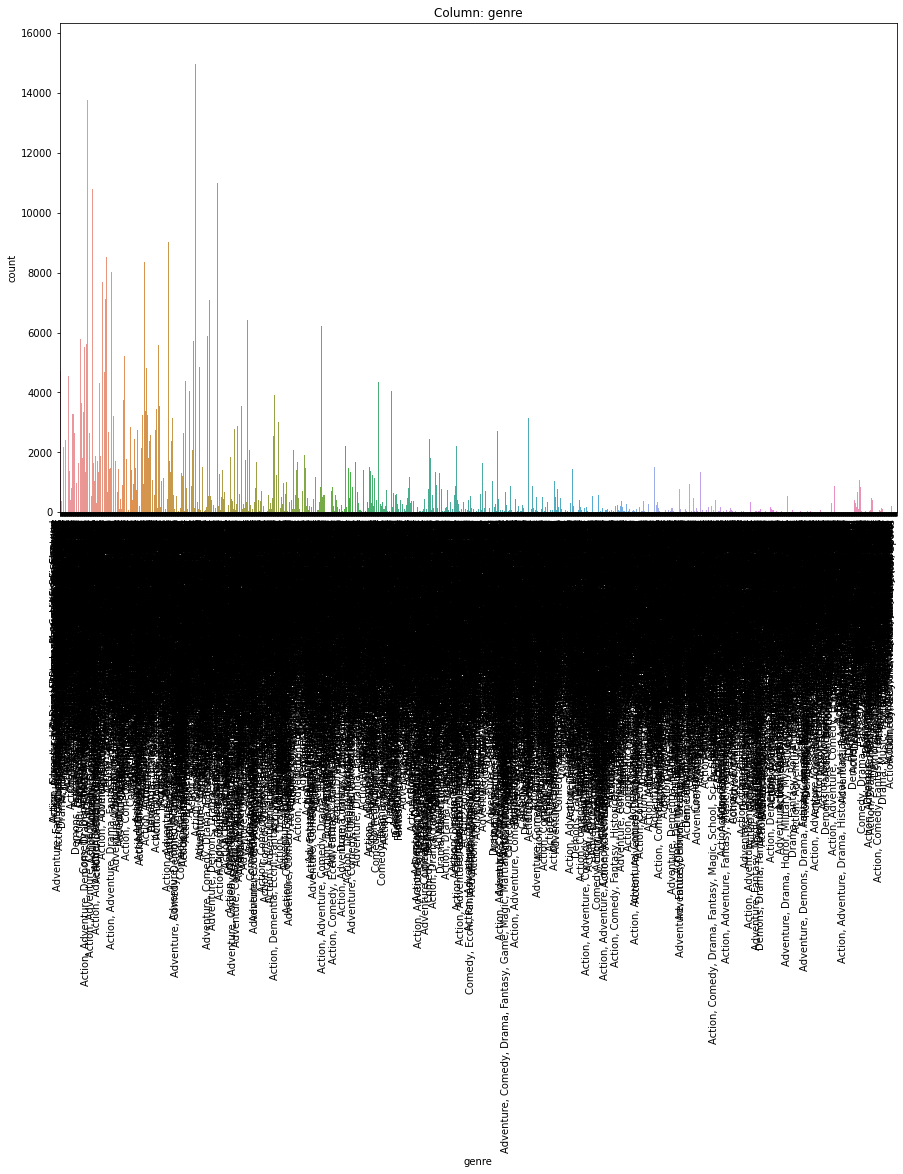

- NaN's Found: 47 (0.0%)
- Unique Values: 2963
- Most common value: 'Comedy, School, Slice of Life' occurs 15551 times (0.75%)
- Not constant or quasi-constant.


(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':'Column: genre'}, xlabel='genre', ylabel='count'>)

In [101]:
explore_categorical(combinedata, x = 'genre', fillna = True, placeholder = 'MISSING',
                        figsize = (15,9), order = None)

#### Inspect type


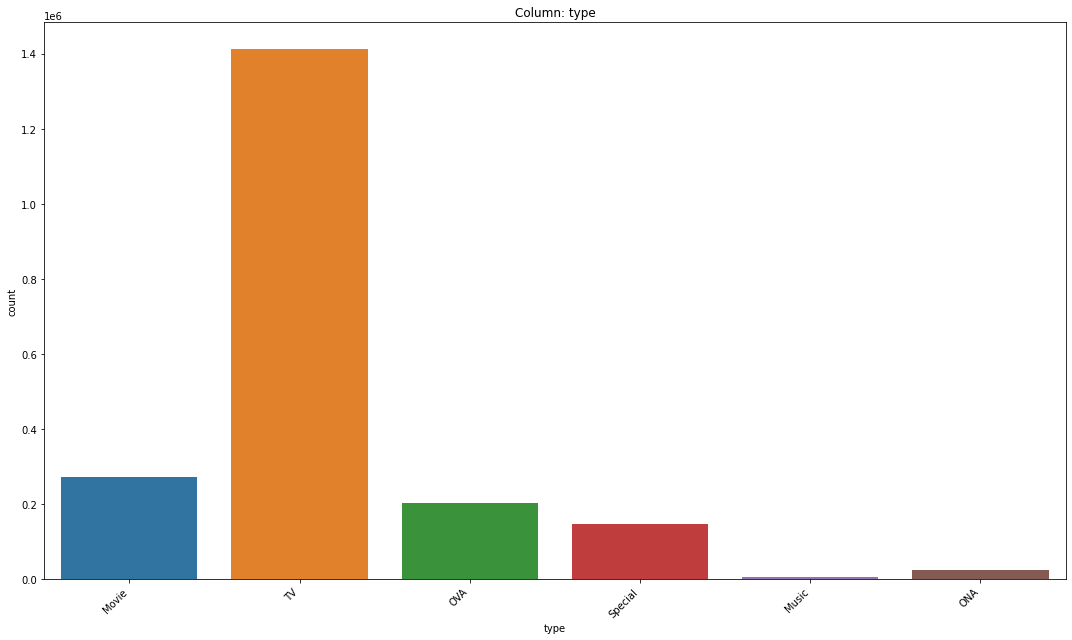

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'TV' occurs 1412670 times (68.39%)
- Not constant or quasi-constant.


(<Figure size 1080x648 with 1 Axes>,
 <AxesSubplot:title={'center':'Column: type'}, xlabel='type', ylabel='count'>)

In [97]:
explore_categorical(combinedata, x = 'type', fillna = True, placeholder = 'MISSING',
                        figsize = (15,9), order = None)

#### Inspect anime_id


#### Inspect anime_id


In [62]:
type_groupby = unknown.groupby('type',as_index=True)
means = type_groupby.mean()
means

,anime_id,rating,members
type,,,
Movie,32576.500000,5.360000,1749.250000
Music,33108.000000,5.750000,38.000000
ONA,30621.347826,5.791905,261.543478
OVA,32114.180000,6.744737,1608.760000
Special,33174.200000,5.748000,2106.800000
TV,29755.832536,5.953465,11089.875598


In [ ]:
# Explore categorical columns

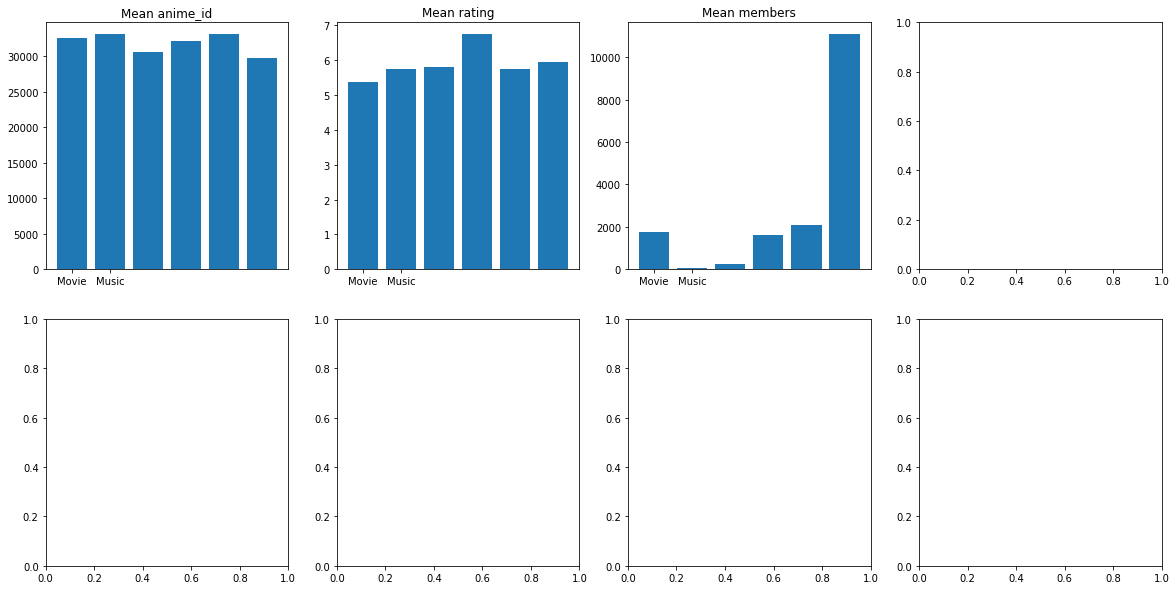

In [63]:
# Visualize means
# Only need to do 2 of these visualizations.  Might not use loop or subplots
fig, axes = plt.subplots(2,4, figsize = (20, 10))
ax = 0
axes = axes.ravel()
for col in means.columns:
  axes[ax].bar(means.index, means[col])
  axes[ax].set_title(f'Mean {col}')
  axes[ax].set_xticks([0,1])
  ax += 1

In [49]:
len(rating['user_id'].unique())

73515

In [50]:
len(rating['anime_id'].unique())

11200

In [52]:
len(anime['anime_id'].unique())

12294

In [5]:
# Preview all object columns from ratings
rating.select_dtypes("object").head()

""
0
1
2
3
4


In [ ]:
- 